# Composite mass tracks in asari

This notebook illustrates the concept of composite mass tracks in asari (version 1.8.0).

Similar set of peaks are presenet across samples. Instead of doing peak detection in each sample, their signals are combined into a composite mass track per m/z region and peak detection is done on the composite mass tracks.

This greatly improves computing efficiency for large studies, reduces errors in peak correspondence across samples, and results in better peak detection for weak signals.

The result can be negatively affected by bad retention time alignment. But retention time alignment is a separate problem, and it does not have more impact to the asari approach than to XCMS or other approaches.

The demo data are MT01 dataset, processed as:

`>>> asari process --input /Users/shuzhao/bulk/MT01 --output MT01 --ppm 5`

In [1]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt

datadir = 'asari_project_MT01_51162751'

Directory structure:
```
    asari_project_MT01_51162751
    ├── Annotated_empricalCompounds.json
    ├── Feature_annotation.tsv
    ├── export
    │   ├── _mass_grid_mapping.csv
    │   ├── cmap.pickle
    │   ├── full_Feature_table.tsv
    │   └── unique_compound__Feature_table.tsv
    ├── pickle
    │   ├── Blank_20210803_003.pickle
    │   ├── Blank_20210803_005.pickle
    │   ├── MSplate10_pgpB_b1278_G5_platePN_rep2_HEAT_GEIII_0-829_1125.pickle
    │   ├── MT_20210803_003K-Qstd.pickle
    │   ├── MT_20210803_005-NIST.pickle
    │   ├── MT_20210803_051.pickle
    │   ├── MT_20210803_089-Qstd.pickle
    │   ├── MT_20210803_091.pickle
    │   ├── MT_20210803_139.pickle
    │   └── MT_20210803_181.pickle
    ├── preferred_Feature_table.tsv
    └── project.json
```

In [2]:
# load composite map
cmap = pickle.load( open(os.path.join(datadir, 'export', 'cmap.pickle'), 'rb') )

In [3]:
cmap.keys()

dict_keys(['_number_of_samples_', 'rt_length', 'dict_scan_rtime', 'list_mass_tracks', 'MassGrid'])

In [4]:
# example mass track
cmap['list_mass_tracks'][583]

{'id_number': 583,
 'mz': 137.04570511938525,
 'intensity': array([106967,  64100,  65847, ...,      0,      0,      0])}

In [5]:
def plotk(track, color='m', start=100, end=400, yticks=[0, 5e7, 1e8]):
    plt.figure(figsize=(8, 4))
    X = range(start, end)
    Y = track['intensity'][start: end]
    plt.plot(X, Y, color=color, marker='o', markersize=4, linestyle='dashed')
    plt.yticks(yticks)

### We plot out composite track 583 as an example

The composite plot shows signals cumulated from all samples.

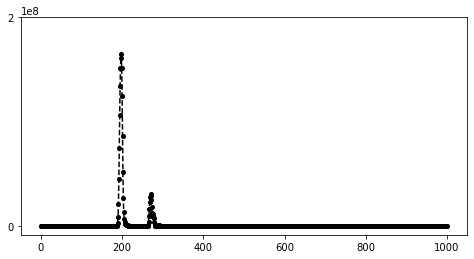

In [6]:
plotk(cmap['list_mass_tracks'][583], color='k', start=00, end=1000, yticks=[0, 2e8])

The composite mass tracks in CMAP are cumulated signals from all samples. 

**Now we look up how a composite mass track corresponds to the mass track in individual samples.**

In [7]:
# read CMAP - the file _mass_grid_mapping.csv records how mass tracks are mapped 
# Same information is stored as dictionaries in cmap['MassGrid']
cmap = pd.read_csv(os.path.join(datadir, 'export', '_mass_grid_mapping.csv'), index_col=0)
cmap

,mz,Blank_20210803_003,Blank_20210803_005,MSplate10_pgpB_b1278_G5_platePN_rep2_HEAT_GEIII_0-829_1125,MT_20210803_003K-Qstd,MT_20210803_005-NIST,MT_20210803_051,MT_20210803_089-Qstd,MT_20210803_091,MT_20210803_139,MT_20210803_181
0,80.947788,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,80.987470,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN
2,80.988352,NaN,1.0,NaN,1.0,2.0,1.0,2.0,2.0,1.0,1.0
3,81.044663,0.0,2.0,NaN,2.0,3.0,2.0,3.0,3.0,2.0,2.0
4,81.520508,1.0,3.0,NaN,3.0,4.0,3.0,4.0,4.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
13850,886.632497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6863.0
13851,959.518341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6917.0
13852,986.504486,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6924.0
13853,997.624420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6932.0


In [8]:
# Use 3 samples for illustrration
myfiles = ['MT_20210803_089-Qstd', 'MT_20210803_139', 'MT_20210803_181']

In [9]:
cmap[myfiles].iloc[583, :]

MT_20210803_089-Qstd    583.0
MT_20210803_139         588.0
MT_20210803_181         572.0
Name: 583, dtype: float64

The above cell shows the mass track number in each sample in myfiles, corresponding to number 583 in the composoite map.

They should be integer. Pandas loads as float because we didn't ask it to force dtype.

Next, we load mass tracks from each of the three samples from intermedaite pickle files asari saved during processing.

In [10]:
data = []
for f in myfiles:
    with open(os.path.join(datadir, 'pickle', f+'.pickle'), 'rb') as O:
        data.append(pickle.load( O ))
    

In [11]:
# check what's in the first sample data
data[0].keys()

dict_keys(['sample_id', 'input_file', 'ion_mode', 'max_scan_number', 'list_mass_tracks', 'anchor_mz_pairs', 'number_anchor_mz_pairs'])

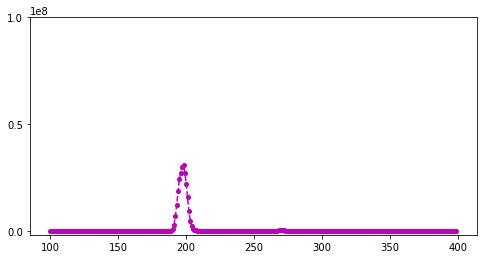

In [12]:
# first sample, MT_20210803_089-Qstd
plotk(data[0]['list_mass_tracks'][583],
              color='m', start=100, end=400, yticks=[0, 0.5e8, 1e8])

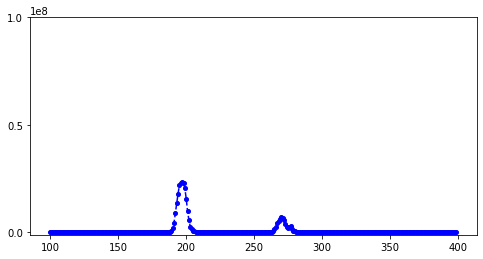

In [13]:
# second sample, MT_20210803_139
plotk(data[1]['list_mass_tracks'][588],
              color='b', start=100, end=400, yticks=[0, 0.5e8, 1e8])

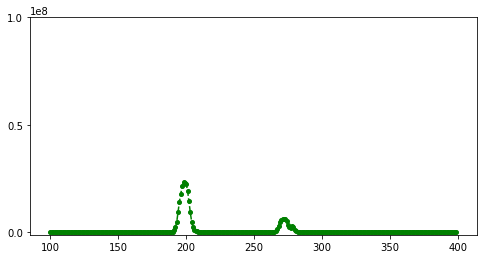

In [14]:
# third sample, MT_20210803_181
plotk(data[2]['list_mass_tracks'][572],
              color='g', start=100, end=400, yticks=[0, 0.5e8, 1e8])

### Let's add up the signals from all 3 samples. That's how a composite mass track is constructed.

In asari, the sample data go through retention time calibration first. We skip it here.

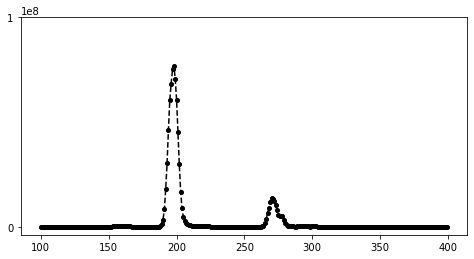

In [15]:
composite = {'intensity': data[0]['list_mass_tracks'][583]['intensity'][:400] + data[1
                                ]['list_mass_tracks'][588]['intensity'][:400] + data[2
                                ]['list_mass_tracks'][572]['intensity'][:400] }

plotk(composite,
              color='k', start=100, end=400, yticks=[0, 1e8])

The two peaks here are reported as features F3345 and F3346 on parent track 583.

In the asari feature table, there's a third peak due to cumulative signals from other samples on the same track.

After peak detection on composite mass tracks, the corresponding regions of each sample are looked up to get peak area values.